# Multi-Task Learning in Neural Networks and its Connection to Representations

## ariel maymon. 208934216
### Final project

In case some datasets won't download due to temporary erros, download manually and put inside folder. Othercells should work right out of the box.

Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image
import os
import time
import random
import zipfile 
import gdown
from natsort import natsorted
import pandas as pd
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset

Utilities and helper functions

In [ ]:
#load image as tensor (image path -> tensor)
def load_image(path):
    img  = Image.open(path)
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    return img

#convert image to tensor (image -> tensor)
def img_to_tensor(img):
    transform = transforms.Compose([transforms.ToTensor()])
    img = transform(img)
    return img

#display img tensor as RGB image (tensor -> real imange)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#print model parameters
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name, param.data)

#copy model parameters from source to target        
def copy_params(source, target):
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

def save_model(model):
    torch.save(model.state_dict(), './model.pt')#name + '_'+str(i)+'.pt')

def clean_data(data):
    data = data[data.sum(axis=1) != 1]

#seed the environment.
def init_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

#### Cub2011 custom pytorch dataset (source: http://www.vision.caltech.edu/visipedia/CUB-200-2011.html)
taken from https://github.com/TDeVries/cub2011_dataset

In [ ]:
class Cub2011(Dataset):
    base_folder = 'CUB_200_2011/images'
    url = 'http://www.vision.caltech.edu/visipedia-data/CUB-200-2011/CUB_200_2011.tgz'
    gd_url = 'https://drive.google.com/uc?id=1hbzc_P1FuxMkcabkgn9ZKinBwW683j45'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, loader=default_loader, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')
        
        '''
        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]
        '''    
        

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target
    
    def get_batch(self,start,end):
        imgs = []
        for idx in range(start,end+1):
            sample = self.data.iloc[idx]
            path = os.path.join(self.root, self.base_folder, sample.filepath)
            target = sample.target - 1  # Targets start at 1 by default, so shift to 0
            img = self.loader(path)

            if self.transform is not None:
                img = self.transform(img)
            
            imgs.append(img)
        
        return imgs

#### CelebA custom pytorch dataset (source: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

In [ ]:
## Create a custom Dataset class
class CelebADataset(Dataset):
  def __init__(self, root_dir,attr_path,eval_path, split='train', transform=None,with_attribute=True):
    """
    Args:
      root_dir (string): Directory with all the images
      attr_path(string): path to attribute data
      eval_path(string): path to eval data
      split: split for data - train, val, test
      transform (callable, optional): transform to be applied to each image sample
    """
    # Read names of images in the root directory
    image_names = os.listdir(root_dir)
    self.with_attribute = with_attribute
    
    self.root_dir = root_dir
    self.transform = transform 
    
    #load attributes
    self.attributes = pd.read_csv(attr_path, delim_whitespace=True, header=1)
    
    #load split
    partition  = pd.read_csv(eval_path,  sep=' ', names=['split'])
    self.attributes['split'] = partition['split']
    
    #train,val or test
    if split == 'train':
        self.attributes = self.attributes[self.attributes['split'] == 0]
    elif split == 'val':
        self.attributes = self.attributes[self.attributes['split'] == 1]
    elif split == 'test':
        self.attributes = self.attributes[self.attributes['split'] == 2]
    
    # shift from values (-1,1) to (0,1)
    self.attributes = (self.attributes+1) // 2
    
    # delete rows without an attribute (hair color)
    self.attributes = self.attributes[self.attributes[['Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair']].sum(axis=1) == 1]
    
    #set main target to Male vs Female classification, squeeze(1) for compatibility with CE loss
    self.targets = torch.as_tensor(self.attributes[['Male']].values)
    self.targets = self.targets.squeeze(1)
    
    #set attribute target
    self.attributes = self.attributes[['Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair']]
    
    #extras
    self.attr_names = list(self.attributes.columns)
    self.image_names = natsorted(self.attributes.index.values)
    
    #make attribute a tensor and move from one hot encoding to normal
    self.attributes = torch.as_tensor(self.attributes.values)
    self.attributes = torch.argmax(self.attributes,dim=1)#.unsqueeze(1)
    
    #if one-hot
    #self.targets = torch.nn.functional.one_hot(self.targets,2)


  def __len__(self): 
    return len(self.image_names)

  def __getitem__(self, idx: int):
    # Get the path to the image 
    img_path = os.path.join(self.root_dir, self.image_names[idx])
    # Load image and convert it to RGB
    img = Image.open(img_path).convert('RGB')
    # Apply transformations to the image
    if self.transform:
      img = self.transform(img)
    
    if not self.with_attribute:
        return img,self.targets[idx]
    
    target = []
    target.append(self.targets[idx])
    target.append(self.attributes[idx])

    return img,target


Setup

In [ ]:
## Setup
# Number of gpus available
ngpu = 1
device = torch.device('cuda:0' if (
    torch.cuda.is_available() and ngpu > 0) else 'cpu')

## Fetch data from Google Drive 
# Root directory for the dataset
data_root = 'data/celeba'
# Path to folder with the dataset
dataset_folder = f'{data_root}/img_align_celeba'
# URL for the CelebA dataset
url = 'https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH'
# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'

attr_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U"
attr_path = f'{data_root}/list_attr_celeba.txt'

eval_url = "https://drive.google.com/uc?id=0B7EVK8r0v71pdjI3dmwtNm5jRkE"
eval_path = f'{data_root}/list_eval_partition.txt'

# Create required directories 
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(dataset_folder)

In case you don't have CelebA dataset, run this cell:

In [ ]:
# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)
#download attr
gdown.download(attr_url, attr_path, quiet=False)

#evaluation 
gdown.download(eval_url,eval_path,quiet=False)

# Unzip the downloaded file 
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(dataset_folder)

Downloading...
From: https://drive.google.com/uc?id=1cNIac61PSA_LqDFYFUeyaQYekYPc75NH
To: C:\Users\ARiEL\Desktop\Learn\Bar Ilan\Learning and Perception\data\celeba\img_align_celeba.zip
1.44GB [06:47, 3.54MB/s]


Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=0B7EVK8r0v71pblRyaVFSWGxPY0U 



### Datasets and Dataloaders

In [ ]:
## Load the dataset 
# Path to directory with all the images
img_folder = f'{dataset_folder}/img_align_celeba'
# Spatial size of training images, images are resized to this size.
image_size = 64
# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])


# Batch size during training
batch_size = 64
# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False

main_labels = ('female','male')
attribute_labels = ('black hair','blond hair', 'brown hair','gray hair')

In [ ]:
# Load the dataset from file and apply transformations
celeba_dataset = CelebADataset(img_folder,attr_path,eval_path,split='train', transform = transform)

## Create a dataloader 
celeba_dataloader = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

# Load the dataset from file and apply transformations
celeba_dataset_val = CelebADataset(img_folder,attr_path,eval_path,split='val', transform = transform)

## Create a dataloader 
celeba_dataloader_val = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

Example with target and attribute

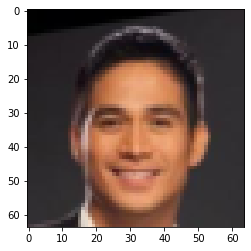

000012.jpg : male , black hair


In [ ]:
def show_image(image_num):    
    imshow(celeba_dataset[image_num][0])
    print(celeba_dataset.image_names[image_num],":",main_labels[celeba_dataset[image_num][1][0].item()],",",attribute_labels[celeba_dataset[image_num][1][1].item()])

show_image(6)

In [ ]:
#print(torch.nn.functional.one_hot(celeba_dataset[4][1][0],2))
#print(celeba_dataset[0][1][0])
#assert(celeba_dataset.attributes == celeba_dataset.attributes).all().item()
celeba_dataset[0]

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.9451,  0.9529,  0.9529],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9451,  0.9529,  0.9451],
          [ 0.9922,  0.9922,  0.9922,  ...,  0.9294,  0.9608,  0.9529],
          ...,
          [ 0.3020,  0.2627,  0.1137,  ...,  0.4196,  0.4510,  0.4510],
          [ 0.3569,  0.2941,  0.2627,  ...,  0.3725,  0.3490,  0.3647],
          [ 0.3882,  0.3647,  0.3804,  ...,  0.5608,  0.4824,  0.4196]],
 
         [[ 0.8431,  0.8431,  0.8431,  ...,  0.8667,  0.8588,  0.8902],
          [ 0.8431,  0.8431,  0.8431,  ...,  0.8824,  0.8667,  0.8980],
          [ 0.8588,  0.8588,  0.8588,  ...,  0.8902,  0.8745,  0.8902],
          ...,
          [-0.2078, -0.2235, -0.3255,  ...,  0.0275,  0.0510,  0.0510],
          [-0.1529, -0.2078, -0.2314,  ..., -0.0667, -0.0667, -0.0353],
          [-0.1294, -0.1373, -0.1059,  ...,  0.1451,  0.0824,  0.0275]],
 
         [[ 0.5529,  0.5529,  0.5529,  ...,  0.6863,  0.7490,  0.7961],
          [ 0.5529,  0.5529,

#### Custom entrpy loss (MultiEntropyLoss) and helper functions for the neural networks and the training phase.

In [ ]:
def multisoftmax(x,chunks):
    x_exp = [torch.exp(chunk) for chunk in torch.split(x,chunks,dim=1)]
    x_sum = [torch.sum(chunk,dim=1,keepdim=True) for chunk in x_exp]
    return [exp/_sum for exp,_sum in zip(x_exp,x_sum)]

def log_multisoftmax(x,chunks):
    return [torch.log(chunk) for chunk in multisoftmax(x,chunks)]

def MCEL(outputs,targets,chunks):
    n = targets.shape[0]
    batch_size = outputs.shape[0]

def MultiCrossEntropyLoss(outputs,targets,chunks):
    assert len(chunks) == len(targets)
    criterion = torch.nn.CrossEntropyLoss()
    losses = [criterion(output,label) for output,label in zip(torch.split(outputs,chunks,dim=1),targets)]
    return losses

def move_inputs_to_device(inputs,labels,with_attribute):
    inputs = inputs.to(device)
    labels = [group.to(device) for group in labels] if with_attribute else labels[0].to(device)
    return inputs,labels

Simple earlystopping regularization, taken from https://github.com/Bjarten/early-stopping-pytorch

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

#### Simple network
Assumes 64x64 image inputs

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self,output_units):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_units)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Train function 

In [ ]:
# 6.1. Train the model. (Fill empty code blocks)
def train_model(model, nepochs,  train_loader,
                  val_loader, optimizer, criterion, with_attribute = False,split=[2,4],combine=False):
    '''
    Train a pytorch model and evaluate it every epoch.
    Params:
    model - a pytorch model to train
    optimizer - an optimizer 
    criterion - the criterion (loss function)
    nepochs - number of training epochs
    train_loader - dataloader for the trainset
    val_loader - dataloader for the valset
    with_attribute - whether or not this model outputs both target and attributes
    split - array indicating the split of neurons in the output layer. each split represents a "task" or output.
    combined - true if should train by both the normal loss and then move to the multi-cross entropy loss.
    '''
    if combine:
        cel = torch.nn.CrossEntropyLoss()
    model.to(device)
    if with_attribute:
        train_losses = [[] for i in range(len(split))]
        val_losses = [[] for i in range(len(split))]
    else:
        train_losses, val_losses = [], []
    
    early_stopping = EarlyStopping(verbose=True)
    for e in range(nepochs):
        if with_attribute:
            running_loss = [0 for i in split]
            running_val_loss = [0 for i in split] 
        else:
            running_loss = 0
            running_val_loss = 0
        for inputs, labels in train_loader:
            
            inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
            # Training pass
            model.train() # set model in train mode

            #Setting grads to zero so it won't accumulate 
            optimizer.zero_grad()

            #computing output and computing nllllllllllllllolls
            outputs = model(inputs)
            if with_attribute:
                losses = criterion(outputs,labels,split)
                if combine and e < 10:
                    #print('ahoi')
                    loss = losses[0]
                else:
                    loss = sum(losses)
            else:
                loss = criterion(outputs,labels)
            
            loss = loss.to(device)
            #give some backprop 
            loss.backward()

            #optimize weight by sgd
            optimizer.step()
            
            if with_attribute:
                losses = [loss.item() for loss in losses]
                running_loss = [a+b for a,b in zip(running_loss,losses)]
            else:
                running_loss += loss.item()
        else:
            
            val_loss = 0
            with torch.no_grad():
                for inputs,labels in val_loader:
                    
                    inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
                    
                    model.eval()
                    
                    outputs = model(inputs)

                    if with_attribute:
                        losses_val = criterion(outputs,labels,split)
                        losses_val = [loss.item() for loss in losses_val]
                        running_val_loss = [a+b for a,b in zip(running_val_loss,losses_val)]
                    else:
                        val_loss = criterion(outputs,labels)
                        running_val_loss += val_loss.item()

            if with_attribute:
                #print(train_losses,running_loss)
                #print(val_losses,running_val_loss)
                train_losses = [x + [y/len(train_loader)] for x,y in zip(train_losses,running_loss)]
                
                val_losses = [x + [y/len(val_loader)] for x,y in zip(val_losses,running_val_loss)]
                
                fmtL = ', '.join(["{:.3f}.."]*len(running_loss))
                print("Epoch: {}/{}.. ".format(e+1, nepochs),
                    "Training Loss: ",fmtL.format(*[x/len(train_loader) for x in running_loss]),
                    "\n Validation Loss: ",fmtL.format(*[x/len(val_loader) for x in running_val_loss]))
                early_stopping(running_val_loss[0]/len(val_loader),model)
                
            else:
                train_losses.append(running_loss/len(train_loader))
                val_losses.append(running_val_loss/len(val_loader))

                print("Epoch: {}/{}.. ".format(e+1, nepochs),
                    "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                    "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
                
                early_stopping(running_val_loss/len(val_loader),model)
            
            
            
            if early_stopping.early_stop:
                print("Early stopping at epoch:",i)
                break
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses

#### Evaluation functions
All functions work for both the regular network as well for a multi-attribute one.

In [ ]:
#Evaluate model on a loader.
def evaluate_model(model, loader, with_attribute = False,split = [2,4]):
    loader_accuracy = [0]*len(split) if with_attribute else 0
    model.to(device)
    model.eval()
    with torch.no_grad():
        for inputs,labels in loader:
            
            inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
            
            outputs = model(inputs)
            
            if with_attribute:
                predictions = [torch.max(output,1)[1] for output in torch.split(outputs,split,dim=1)]
                batch_accuracy = [torch.sum((i == j).type(torch.FloatTensor)) for i,j in zip(labels,predictions)]
                loader_accuracy = [x+y for x,y in zip(loader_accuracy,batch_accuracy)]
            
            else:
                predictions = torch.max(outputs,1)[1]
                batch_accuracy = torch.sum((labels == predictions).type(torch.FloatTensor))
                loader_accuracy += batch_accuracy
    loader_accuracy = [acc/len(loader.dataset) for acc in loader_accuracy] if with_attribute else loader_accuracy/len(loader.dataset)
    return loader_accuracy

#Predict an example from the lodaer (data)
def predict(model, loader, with_attribute = False,split=[2,4]):
    model.to(device)
    
    dataiter = iter(loader)
    inputs, labels = dataiter.next()
    inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
    
    example = inputs[0].unsqueeze(0)
    
    with torch.no_grad():
        out = model(example)
    
    if with_attribute:
        res = [torch.max(output,1)[1] for output in torch.split(out,split,dim=1)]
    else:
        res = torch.max(out,1)[1]
    
    return res

# Visualize set of samples. Originally from pytorch custom function.
def visualize_samples(model,loader,with_attribute=True,split=[2,4],num=12):
    model.eval()
    model.to(device)
    dataiter = iter(loader)
    inputs, labels = dataiter.next()
    inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
    with torch.no_grad():    
        outputs = model(inputs)
        
    if with_attribute:
        res = [torch.max(output,1)[1] for output in torch.split(outputs,split,dim=1)]
    else:
        res = torch.max(out,1)[1]
    
    fig = plt.figure(figsize=(30,20))
    inputs = inputs.cpu().numpy()
    plt.rcParams.update({'font.size': 22})
    for idx in np.arange(num):
        ax = fig.add_subplot(3,num/3,idx+1,xticks=[],yticks=[])
        img = inputs[idx] / 2 + 0.5     # unnormalize
        ax.imshow(np.transpose(img, (1, 2, 0)))
        if with_attribute:
            ax.set_title("{},{} \n ({},{})".format(main_labels[res[0][idx]], \
                                               attribute_labels[res[1][idx]], \
                                               main_labels[labels[0][idx]], \
                                               attribute_labels[labels[1][idx]]), color = ("green" if res[0][idx] == labels[0][idx] else "red"))
        else:
            ax.set_title("{} \n ({})".format(main_labels[res[idx]], \
                                               main_labels[labels[0][idx]]), color = ("green" if res[idx] == labels[idx] else "red"))

#Evaluate model, separated by the different classes.
def evaluate_model_by_class(model,loader,with_attribute = False,split = [2,4]):
    class_correct = [list(0. for i in range(x)) for x in split] if with_attribute else list(0. for i in range(len(main_labels)))
    class_total = [list(0. for i in range(x)) for x in split] if with_attribute else list(0. for i in range(len(main_labels)))
    model.to(device)
    model.eval()
    
    with torch.no_grad():
        for inputs,labels in loader:
            inputs, labels = move_inputs_to_device(inputs,labels,with_attribute)
            outputs = model(inputs)
            
            if with_attribute:
                predictions = [torch.max(output,1)[1] for output in torch.split(outputs,split,dim=1)]
                c = [i == j for i,j in zip(labels,predictions)]
                
                for i in range(len(split)):
                    for j in range(len(outputs)):
                        label = labels[i][j]
                        #rint(class_correct)
                        class_correct[i][label] += c[i][j].item()
                        class_total[i][label] += 1
                
            else:
                predictions = torch.max(outputs,1)[1]
                c = (predictions == labels).squeeze()
                
                for j in range(len(outputs)):
                    label = labels[j]
                    class_correct[label] += c[j].item()
                    class_total[label] += 1
                    
    classes = [np.divide(x,y) for x,y in zip(class_correct,class_total)]
    return classes        

### Training and evaluating

In [ ]:
import torch.optim as optim

#criterion = MCEL()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
cel = torch.nn.CrossEntropyLoss()
epochs = 40

In [ ]:
att_train_losses, att_val_losses, att_times = [],[],[]
reg_train_losses, reg_val_losses, reg_times = [],[],[]
att_evals, att_class_evals = [],[]
reg_evals, reg_class_evals = [],[]

In [ ]:
# Load the dataset from file and apply transformations
celeba_dataset_test = CelebADataset(img_folder,attr_path,eval_path,split='test', transform = transform)

## Create a dataloader 
celeba_dataloader_test = torch.utils.data.DataLoader(celeba_dataset,
                                                batch_size=batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

In [ ]:
for i in range(3):
    init_seed(i)
    attr_net = Net(len(main_labels)+len(attribute_labels)).to(device)
    init_seed(i)
    reg_net = Net(len(main_labels)).to(device)
    reg_net.fc3.bias.data.copy_(attr_net.fc3.bias[0:2].data)
    
    init_seed(i)
    
    optimizer = optim.Adam(attr_net.parameters(), lr=0.001)
    start = time.time()
    train_losses, val_losses = train_model(attr_net,epochs,celeba_dataloader,celeba_dataloader_val,optimizer,MultiCrossEntropyLoss,True)
    end = time.time()
    att_times.append(end-start)
    att_train_losses.append(train_losses)
    att_val_losses.append(val_losses)
    
    print('Saving attr',i)
    torch.save(attr_net.state_dict(), 'attr_'+str(i)+'.pt')
    
    print('Eval attr')
    att_evals.append(evaluate_model_by_class(attr_net, celeba_dataloader_test, True))
    
    init_seed(i)
    start = time.time()
    optimizer = optim.Adam(reg_net.parameters(), lr=0.001)
    train_losses, val_losses = train_model(reg_net,epochs,celeba_dataloader,celeba_dataloader_val,optimizer,cel,False)
    end = time.time()
    reg_times.append(end-start)
    reg_train_losses.append(train_losses)
    reg_val_losses.append(val_losses)
    
    print('Saving reg',i)
    torch.save(reg_net.state_dict(), 'reg_'+str(i)+'.pt')
    
    print('Eval attr')
    reg_evals.append(evaluate_model_by_class(reg_net, celeba_dataloader_test, False))
    #add time start-end, make sure seeds well, add eval_model function,
    #(also by class?),save model after each iter,move all to gpu
    #then run for 3 eps. 
    #do nice graphs - normal, attr, 

Epoch: 1/40..  Training Loss:  0.190.., 0.426.. 
 Validation Loss:  0.112.., 0.451..
Validation loss decreased (inf --> 0.112024).  Saving model ...
Epoch: 2/40..  Training Loss:  0.109.., 0.301.. 
 Validation Loss:  0.086.., 0.251..
Validation loss decreased (0.112024 --> 0.085538).  Saving model ...
Epoch: 3/40..  Training Loss:  0.090.., 0.272.. 
 Validation Loss:  0.091.., 0.299..
EarlyStopping counter: 1 out of 7
Epoch: 4/40..  Training Loss:  0.080.., 0.248.. 
 Validation Loss:  0.062.., 0.217..
Validation loss decreased (0.085538 --> 0.061575).  Saving model ...
Epoch: 5/40..  Training Loss:  0.070.., 0.229.. 
 Validation Loss:  0.072.., 0.197..
EarlyStopping counter: 1 out of 7
Epoch: 6/40..  Training Loss:  0.061.., 0.212.. 
 Validation Loss:  0.056.., 0.192..
Validation loss decreased (0.061575 --> 0.056500).  Saving model ...
Epoch: 7/40..  Training Loss:  0.053.., 0.196.. 
 Validation Loss:  0.037.., 0.167..
Validation loss decreased (0.056500 --> 0.037146).  Saving model .

RuntimeError: start (2) + length (4) exceeds dimension size (2).

In [ ]:
init_seed(0)
start = time.time()
optimizer = optim.Adam(reg_net.parameters(), lr=0.001)
train_losses, val_losses = train_model(reg_net,epochs,celeba_dataloader,celeba_dataloader_val,optimizer,cel,False)
end = time.time()
reg_times.append(end-start)
reg_train_losses.append(train_losses)
reg_val_losses.append(val_losses)

print('Saving reg',i)
torch.save(reg_net.state_dict(), 'reg_'+str(i)+'.pt')

print('Eval attr')
reg_evals.append(evaluate_model_by_class(reg_net, celeba_dataloader_test, False))

Epoch: 1/40..  Training Loss: 0.153..  Validation Loss: 0.095.. 
Validation loss decreased (inf --> 0.095099).  Saving model ...
Epoch: 2/40..  Training Loss: 0.092..  Validation Loss: 0.080.. 
Validation loss decreased (0.095099 --> 0.080175).  Saving model ...
Epoch: 3/40..  Training Loss: 0.076..  Validation Loss: 0.059.. 
Validation loss decreased (0.080175 --> 0.059178).  Saving model ...
Epoch: 4/40..  Training Loss: 0.065..  Validation Loss: 0.048.. 
Validation loss decreased (0.059178 --> 0.048341).  Saving model ...
Epoch: 5/40..  Training Loss: 0.054..  Validation Loss: 0.043.. 
Validation loss decreased (0.048341 --> 0.043263).  Saving model ...
Epoch: 6/40..  Training Loss: 0.046..  Validation Loss: 0.040.. 
Validation loss decreased (0.043263 --> 0.040207).  Saving model ...
Epoch: 7/40..  Training Loss: 0.037..  Validation Loss: 0.034.. 
Validation loss decreased (0.040207 --> 0.033903).  Saving model ...
Epoch: 8/40..  Training Loss: 0.031..  Validation Loss: 0.025.. 
Va

In [ ]:
init_seed(0)
attr_net_combined = Net(len(main_labels)+len(attribute_labels)).to(device)

In [ ]:
init_seed(0)
optimizer = optim.Adam(attr_net_combined.parameters(), lr=0.001)
start = time.time()
train_losses, val_losses = train_model(attr_net_combined,epochs,celeba_dataloader,celeba_dataloader_val,optimizer,MultiCrossEntropyLoss,with_attribute=True,combine=True)
end = time.time()
att_times.append(end-start)
att_train_losses.append(train_losses)
att_val_losses.append(val_losses)

print('Saving attr',0)
torch.save(attr_net_combined.state_dict(), 'attr_combined_'+str(i)+'.pt')

print('Eval attr')
att_evals.append(evaluate_model_by_class(attr_net_combined, celeba_dataloader_test, True))

Epoch: 1/40..  Training Loss:  0.153.., 1.588.. 
 Validation Loss:  0.103.., 1.686..
Validation loss decreased (inf --> 0.102942).  Saving model ...
Epoch: 2/40..  Training Loss:  0.092.., 1.663.. 
 Validation Loss:  0.077.., 1.659..
Validation loss decreased (0.102942 --> 0.076546).  Saving model ...
Epoch: 3/40..  Training Loss:  0.076.., 1.739.. 
 Validation Loss:  0.058.., 1.739..
Validation loss decreased (0.076546 --> 0.058383).  Saving model ...
Epoch: 4/40..  Training Loss:  0.064.., 1.815.. 
 Validation Loss:  0.045.., 1.768..
Validation loss decreased (0.058383 --> 0.045039).  Saving model ...
Epoch: 5/40..  Training Loss:  0.052.., 1.829.. 
 Validation Loss:  0.040.., 1.889..
Validation loss decreased (0.045039 --> 0.040297).  Saving model ...
Epoch: 6/40..  Training Loss:  0.046.., 1.856.. 
 Validation Loss:  0.033.., 1.825..
Validation loss decreased (0.040297 --> 0.032972).  Saving model ...
Epoch: 7/40..  Training Loss:  0.037.., 1.869.. 
 Validation Loss:  0.028.., 1.94

#### Plot losses

In [ ]:
def plot_loss(t_losses,v_losses):
    plt.plot(range(1,len(t_losses)+1),t_losses, label='Training Loss')
    plt.plot(range(1,len(v_losses)+1),v_losses,label='Validation Loss')
    minposs = v_losses.index(min(v_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early stopping')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.grid(True)
    plt.legend()
    #plt.tight_layout()
    plt.show()
    #fig.savefig('loss_plot_reg0.png', bbox_inches='tight')

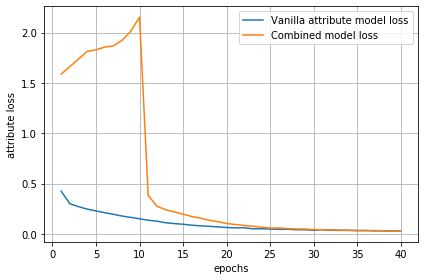

In [ ]:
#plt.plot(range(1,len(reg_train_losses[0])+1),reg_train_losses[0] \
#         , label='Regular model loss (no attribute)')
plt.plot(range(1,len(att_train_losses[0][1])+1),att_train_losses[0][1] \
         , label='Vanilla attribute model loss')
plt.plot(range(1,len(att_train_losses[1][1])+1),att_train_losses[1][1] \
         ,label='Combined model loss')
plt.xlabel('epochs')
plt.ylabel('attribute loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
#plot_loss(att_train_losses[1][0],att_train_losses[1][0])

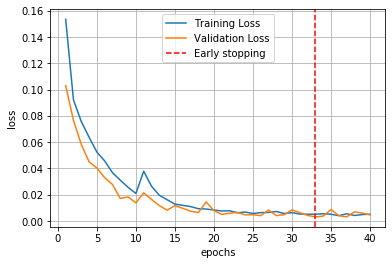

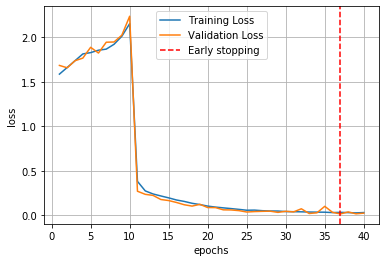

In [ ]:
plot_loss(att_train_losses[1][0],att_val_losses[1][0])
plot_loss(att_train_losses[1][1],att_val_losses[1][1])

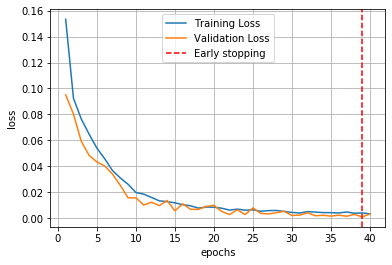

In [ ]:
plot_loss(reg_train_losses[0],reg_val_losses[0])

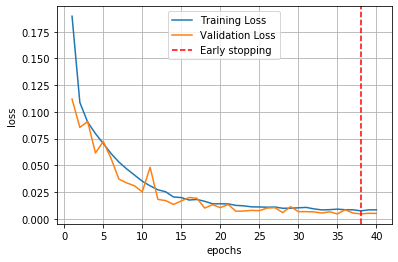

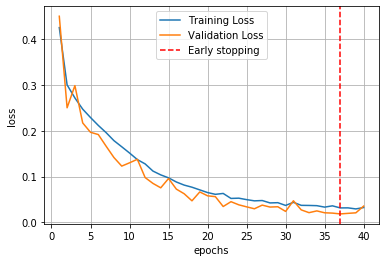

In [ ]:
plot_loss(att_train_losses[0][0],att_val_losses[0][0])
plot_loss(att_train_losses[0][1],att_val_losses[0][1])

Visualizing some samples.

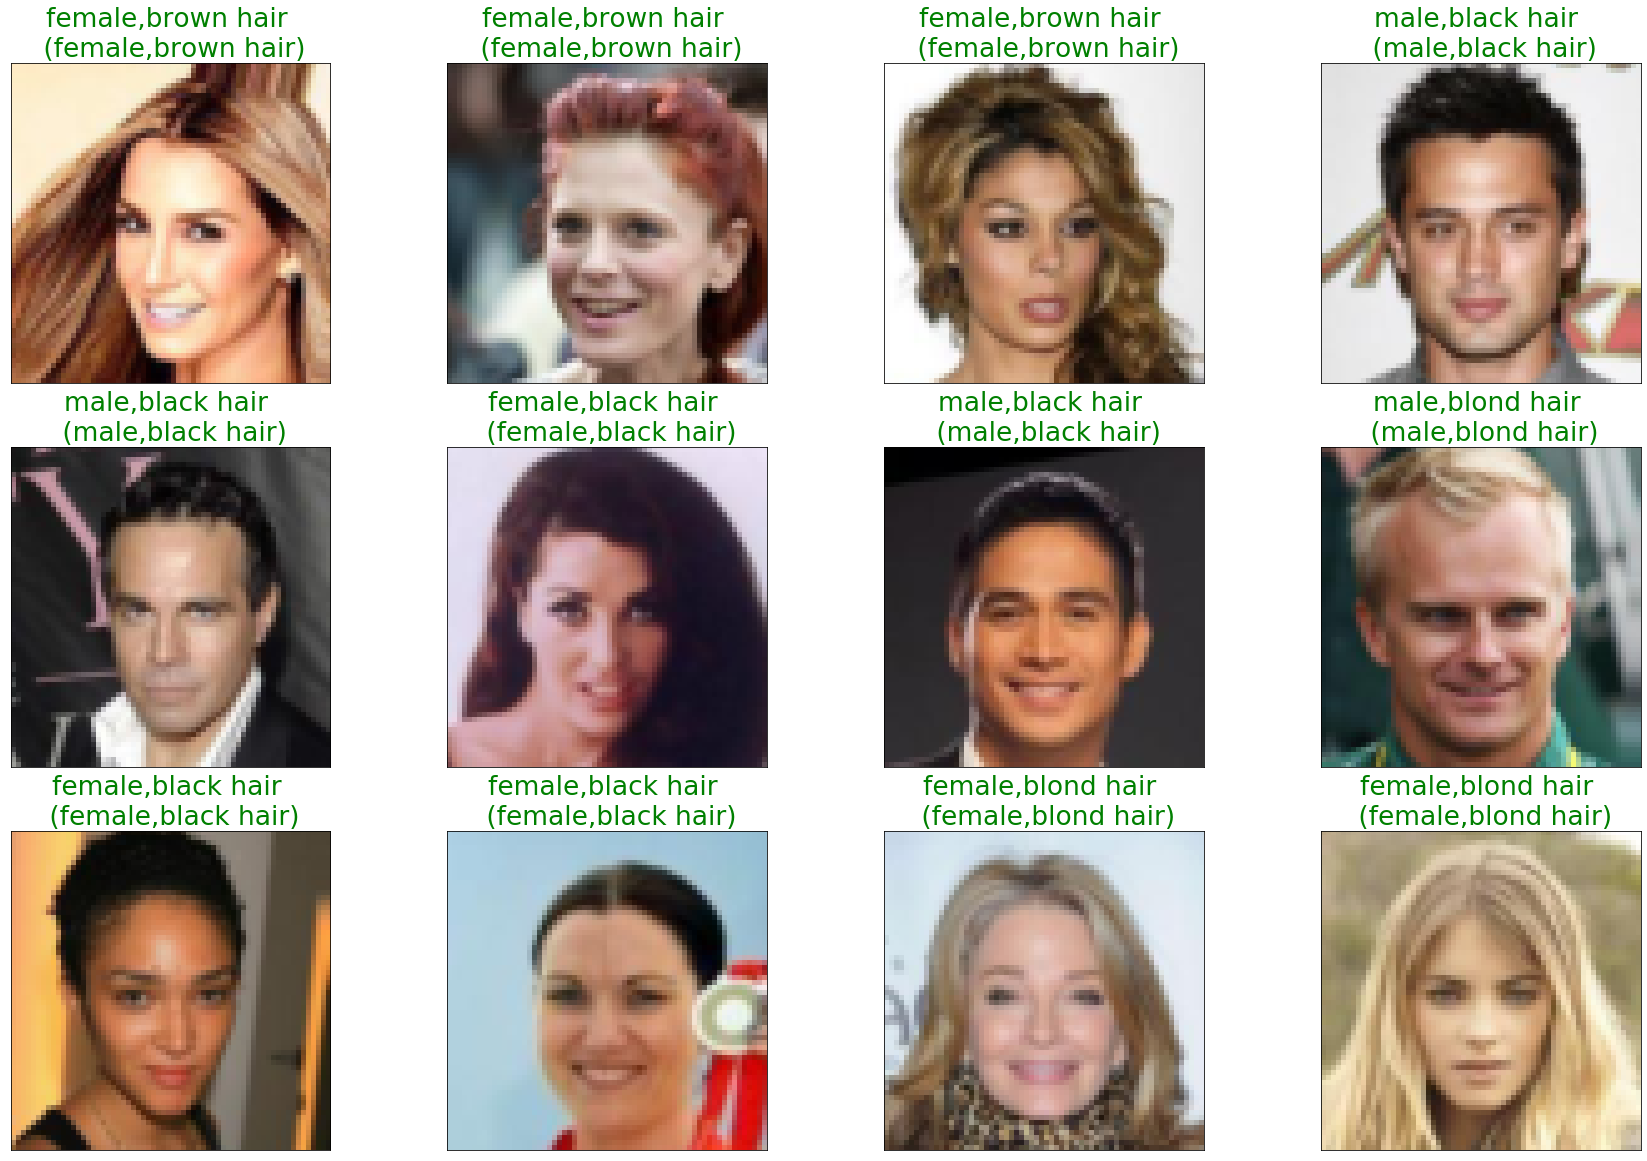

In [ ]:
visualize_samples(attr_net,celeba_dataloader_test,True)

Make CUB dataset

In [ ]:
from collections import Counter
import operator
## Create a dataloader 
CUB = Cub2011('./CUB',transform = transform, download=False)
cub_dataloader = torch.utils.data.DataLoader(CUB,
                                                batch_size=30,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=False)

In [ ]:
model = Net(len(main_labels)+len(attribute_labels)).to(device)
model.load_state_dict(torch.load('attr_combined_0.pt'))

<All keys matched successfully>

In [ ]:
CUB.data['img_id'] -= 1

In [ ]:
cubs = [x for _, x in CUB.data.groupby(CUB.data['target'])]

In [ ]:
cub_classes_attribute = []
model.eval()
model.to(device)
for cub in cubs:
    start = cub['img_id'].values[0]
    end = cub['img_id'].values[-1]
    batch = torch.stack(CUB.get_batch(start,end))
    batch = batch.to(device)
    
    with torch.no_grad():
        out = model(batch)
    
    res = [torch.max(output,1)[1] for output in torch.split(out,[2,4],dim=1)]
    stats = Counter(res[1].cpu().numpy())
    cub_classes_attribute.append( (max(stats.items(), key=operator.itemgetter(1)), len(cub['img_id'].values)) )

In [ ]:
with open(os.path.join(CUB.root, 'CUB_200_2011', 'classes.txt'),"r") as a_file:
    lines = a_file.readlines()

In [ ]:
cub_classes = [line.split(' ')[1].rstrip() for line in lines]

In [ ]:
cub_labels = [(cl,attribute_labels[att[0][0]],att[0][1]/att[1]) for cl,att in zip(cub_classes,cub_classes_attribute)]

In [ ]:
with open(os.path.join(CUB.root, r'CUB_200_2011\attributes', 'image_attribute_labels.txt'),"r") as a_file:
    lines = a_file.readlines()
lines = [line.split(' ')[2] for line in lines]
cub_attributes = 312 #this is given in the CUB dataset
chunks = [lines[x:x+cub_attributes] for x in range(0, len(lines), cub_attributes)]
att_data = pd.DataFrame(chunks)
att_data.columns += 1
#'Black_Hair','Blond_Hair','Brown_Hair','Gray_Hair'
# 260,255,250,254
att_data = att_data[[260,255,250,254]]
for column in att_data.columns:
    att_data[column] = pd.to_numeric(att_data[column]) 
#make attribute a tensor and move from one hot encoding to normal
#att_data_tensor = torch.as_tensor(att_data.values)
#att_data_tensor = torch.argmax(att_data_tensor,dim=1)#.unsqueeze(1)

In [ ]:
cub_dict = {260: 'black',255: 'yellow', 250: 'brown', 254: 'gray'}

In [ ]:
true_cub_attribute = []
for cub in cubs:
    start = cub['img_id'].values[0]
    end = cub['img_id'].values[-1]
    true_att = att_data[start:end].sum().idxmax()
    true_cub_attribute.append(cub_dict[true_att])

In [ ]:
list(zip(cub_labels,true_cub_attribute))

[(('001.Black_footed_Albatross', 'black hair', 0.4666666666666667), 'brown'),
 (('002.Laysan_Albatross', 'black hair', 0.4166666666666667), 'black'),
 (('003.Sooty_Albatross', 'black hair', 0.43103448275862066), 'gray'),
 (('004.Groove_billed_Ani', 'black hair', 0.55), 'black'),
 (('005.Crested_Auklet', 'black hair', 0.4772727272727273), 'black'),
 (('006.Least_Auklet', 'black hair', 0.5121951219512195), 'black'),
 (('007.Parakeet_Auklet', 'black hair', 0.5471698113207547), 'black'),
 (('008.Rhinoceros_Auklet', 'black hair', 0.6875), 'black'),
 (('009.Brewer_Blackbird', 'black hair', 0.6949152542372882), 'black'),
 (('010.Red_winged_Blackbird', 'black hair', 0.6), 'black'),
 (('011.Rusty_Blackbird', 'black hair', 0.38333333333333336), 'black'),
 (('012.Yellow_headed_Blackbird', 'black hair', 0.42857142857142855), 'black'),
 (('013.Bobolink', 'black hair', 0.4166666666666667), 'black'),
 (('014.Indigo_Bunting', 'black hair', 0.43333333333333335), 'gray'),
 (('015.Lazuli_Bunting', 'black

In [ ]:
'''
cub_classes_attribute = []
model.eval()
model.to(device)
for cub in cubs:
    start = cub['img_id'].values[0]
    end = cub['img_id'].values[-1]
    batch = torch.stack(CUB.get_batch(start,end))
    inputs, labels = move_inputs_to_device(inputs,labels,False)
    
    with torch.no_grad():
        out = model(inputs)
    
    res = [torch.max(output,1)[1] for output in torch.split(out,[2,4],dim=1)]
    stats = Counter(res[1].cpu().numpy())
    cub_classes_attribute.append(max(stats.items(), key=operator.itemgetter(1)))
'''    

Todo
- download AWA and CUB datasets : Downloaded CUB, CELEBA, understood a bit how to work with torch.dataset. V/ . 
- build dataloader and stuff for them V
    - data loader for train V
    - data loader for val
    - data loader for test
- get all help functions you will need - show, save, etc
    - show image V
    - save model
    - train function, with eval + with torch.no_grad() on val set.
    - seed function
    - copy params of model
    - predict function (2 funcs (simple,w/attribute) or 1 with argument?)
    - plot percentages 
- check them out and build data with 1 attribute: Did for CELEBA
    - celeba V
    - awa,cub: unfeasible due to homogenity of attributes in classes.
- build a simple regular network
    - should it have output neurn for target & attr or only target?
- train without the attribute (regulary) to see you remember stuff
- make own function loss, make sure all with torch commands V
- build attribute network V
- train with attribute and own loss V


Please read project doc again to infer what you should do
1. Run normal one, attr-one, attr-one that start with normal loss and then goes to special. each 3 seeds
2. Compare prediction %, show plots of losses.
3. Send new class not in data to attr-one (maybe animal with skin/hair color?), see if it corresponds with attr output.

options for datasets:
cub/awa - all classes has same attributes. to test attr: leave some classes outside and see if u get attr right.
celeba - images has different attr. divide to 1- gender, 2-hair color. to test attr: ? an aminal?
utkface = images has different attr. divide to - gender, 2-ethnicity/age?. to test attr: ???

about training & comparing - 
as we divide the last layer into 2 layers - attr and class, we can train the same (ignoring loss of attr and its neurons) until our checkpoint and just then do it.

! def seed function :)

    - show image V
    - save model
    - train function, with eval + with torch.no_grad() on val set.
    - seed function
    - copy params of model
    - predict function (2 funcs (simple,w/attribute) or 1 with argument?)
    - plot percentages 